### for data visualize

https://batuhandaz.medium.com/decision-tree-algoritmas%C4%B1-karar-a%C4%9Fac%C4%B1-machine-learning-78d856b1f457
https://ece-akdagli.medium.com/makine-%C3%B6%C4%9Frenmesinde-decision-tree-42a86502ee75
https://erdincuzun.com/makine_ogrenmesi/decision-tree-karar-agaci-id3-algoritmasi-classification-siniflama/

### Import Librarires And Dataset

In [162]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#some settings to show data
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")
target_url = ("datasets/abalone.data")
abalone_df = pd.read_csv(target_url)
headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone_df.columns = headers

### Analyze the Data

In [163]:
abalone_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


In [164]:
abalone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4176 non-null   object 
 1   Length          4176 non-null   float64
 2   Diameter        4176 non-null   float64
 3   Height          4176 non-null   float64
 4   Whole weight    4176 non-null   float64
 5   Shucked weight  4176 non-null   float64
 6   Viscera weight  4176 non-null   float64
 7   Shell weight    4176 non-null   float64
 8   Rings           4176 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


**Get target value**

In [165]:
# If you want the target values to be categorical rather than numeric, this process should be applied.

# for ix in abalone_df.index:
#     row = abalone_df.loc[ix]
#     if row["Rings"] <= 8:
#         abalone_df.loc[ix, 'Rings'] = 'Young'
#     elif row["Rings"] >= 11:
#         abalone_df.loc[ix, 'Rings'] = 'Old'
#     elif row["Rings"] >=9 & row["Rings"] <= 10:
#         abalone_df.loc[ix, 'Rings'] = 'Medium'

In [166]:
def is_numeric_value(x):
    return type(x) == int or type(x) == float

In [167]:
class MyQuestioner:
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def __repr__(self):
        status = "=="
        if is_numeric_value(self.value):
            status = ">="
        return f"Is {headers[self.column]} {status} {self.value}"

    def compare(self, compared):
        val = compared[self.column]
        if is_numeric_value(val):
            return val >= self.value
        else:
            return val == self.value

In [168]:
def partitioner(rows, myQuestion):
    true_rows, false_rows = [], []
    for row in rows:
        if myQuestion.compare(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [169]:
def class_counts(rows):
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        label = row[-1]  # in our dataset format, the label is always the last column
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [170]:
def gini_impurity(rows):  # There are some ways like entropy, but I use gini impurity : 
    #  https://medium.com/machine-learning-t%C3%BCrkiye/karar-agaclari-algoritmasi-b823c23997d0#:~:text=Gini%20impurity%20nedir,%C3%B6l%C3%A7mek%20i%C3%A7in%20kullan%C4%B1labilir.

    impurityValue = 1
    counts = class_counts(rows)

    for label in counts:
        probability_of_label = counts[label] / float(len(rows))
        impurityValue -= probability_of_label ** 2

    return impurityValue

In [171]:
def information_gain(left, right, current_uncertainty):
    # Information Gain: The uncertainty of the starting node, minus the weighted impurity of two child nodes.

    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - (1 - p) * gini_impurity(right) - p * gini_impurity(left)

In [172]:
def find_the_best_split(rows):
    best_gain = 0  # best information gain
    best_question = None
    n_features = len(rows[0]) - 1  # column numbers
    current_uncertainty = gini_impurity(rows)

    for col in range(n_features):  # for each feature
        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value
            question = MyQuestioner(col, val)
            true_rows, false_rows = partitioner(rows, question)  # try partitioner

            if len(true_rows) == 0 or len(false_rows) == 0:  # if there is no dataset, skip
                continue

            gain = information_gain(true_rows, false_rows, current_uncertainty)

            if gain > best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [173]:
class Leaf:  # Leaf node is last of three, it has a value, has not any tree
    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [174]:
class Decision_Node:  # A Decision Node has two branch true or false
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [175]:
def show_my_tree(node, space=""):
    if isinstance(node, Leaf):
        print(space + "Predict", predict_one(node.predictions)) # To write in line as a same indent
        return

    print(space + str(node.question)) # Ask question

    print(space + '--> False/Left:')
    show_my_tree(node.false_branch, space + "  ")

    print(space + '--> True/Right:')
    show_my_tree(node.true_branch, space + "  ")

In [176]:
def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.compare(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [177]:
def predict_one(counts):
    return max(counts, key=counts.get)

In [178]:
 def predict_all(X, tree, options):
    preditions = []
    # preditions = [max(classify(row, tree), key=classify(row, tree).get) for row in X]

    for row in X:
        cl = classify(row, tree)
        preditions.append(max(cl, key=cl.get))

    return preditions

In [179]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [180]:
def builder_without_pruning(rows, attribute_types):
    gain, question = find_the_best_split(rows)

    if gain == 0:
        return Leaf(rows)

    true_rows, false_rows = partitioner(rows, question)
    true_branch = builder_without_pruning(true_rows, attribute_types)  # Recursive call without pruning
    false_branch = builder_without_pruning(false_rows, attribute_types)  # Recursive call without pruning
    
    return Decision_Node(question, true_branch, false_branch)

In [181]:
def builder_with_pruning(rows, max_depth, attribute_types, curr_depth=0):
    if curr_depth <= max_depth:
        gain, question = find_the_best_split(rows)

        if gain == 0:
            return Leaf(rows)

        true_rows, false_rows = partitioner(rows, question)
        true_branch = builder_with_pruning(true_rows, max_depth, attribute_types, curr_depth + 1)  # Recursive call
        false_branch = builder_with_pruning(false_rows, max_depth, attribute_types, curr_depth + 1)  # Recursive call
        
        return Decision_Node(question, true_branch, false_branch)

    return Leaf(rows)

In [182]:
def build_dt(X, y, attribute_types, options):
    rows = np.concatenate((X, y), axis=1).tolist()
    
    if options["pruning"]:
        return builder_with_pruning(rows, options["max_depth"], attribute_types)    
    elif not options["pruning"]:
        return builder_without_pruning(rows, options["max_depth"])

In [183]:
def predict_dt(dt, X, options):
    return np.array(predict_all(X, dt, options))

In [184]:
X = abalone_df.iloc[:, :-1].values
y = abalone_df.iloc[:, -1].values.reshape(-1, 1)

options = {"max_depth": 5, "pruning": False}
attribute_types = abalone_df.dtypes.apply(str).tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=41)

### Show Tree

In [185]:
my_tree = build_dt(X_train, y_train, attribute_types, options)
y_pred = predict_dt(my_tree, X_test, options)
show_my_tree(my_tree)

Is Shell weight >= 0.145
--> False/Left:
  Is Diameter >= 0.225
  --> False/Left:
    Is Shell weight >= 0.022
    --> False/Left:
      Is Whole weight >= 0.0235
      --> False/Left:
        Is Height >= 0.025
        --> False/Left:
          Is Length >= 0.165
          --> False/Left:
            Predict 1
          --> True/Right:
            Predict 4
        --> True/Right:
          Is Shucked weight >= 0.0055
          --> False/Left:
            Is Height >= 0.035
            --> False/Left:
              Is Length >= 0.15
              --> False/Left:
                Predict 3
              --> True/Right:
                Predict 2
            --> True/Right:
              Predict 4
          --> True/Right:
            Is Shucked weight >= 0.0075
            --> False/Left:
              Predict 3
            --> True/Right:
              Is Length >= 0.165
              --> False/Left:
                Predict 5
              --> True/Right:
                Predict 3
     

**Find Confusion Matrices Without K-fold Cross Validation**

In [186]:
print(f"Accuarcy score: {accuracy_score(y_test, y_pred)}")
confusion_matrix(y_test, y_pred)

Accuarcy score: 0.19138755980861244


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  3,  5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  4,  6,  4,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 10, 11, 21, 10,  3,  2,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 13, 16, 25,  7,  3,  1,  1,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  8, 12, 34, 17, 19,  8,  3,  6,  1,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  7,  5, 29, 30, 25, 14,  3,  5,  3,  1,  2,  1,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  6, 21, 26, 26, 15, 14,  6,  5,  4,  0,  1,
         3,  4,  0,  1, 

**Find Confusion Matrices With K-fold Cross Validation**

In [187]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Lists to store accuracy scores & confusion_matrices for each fold
accuracy_scores = []
confusion_matrices = []

# Perform k-fold cross-validation via kf.split(X_train), this function give me an indexes subset of X_train_scaled actualy X_train
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    my_tree = build_dt(X_train, y_train, attribute_types, options)
    y_pred_fold = predict_dt(my_tree, X_val_fold, options)

    # Calculate accuracy and confusion_matrix for current fold
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    cm = confusion_matrix(y_val_fold, y_pred_fold)

    # Store accuracy score and confusion_matrix
    accuracy_scores.append(accuracy)
    confusion_matrices.append(cm)

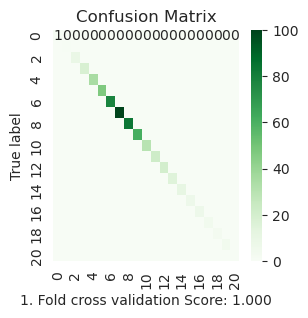

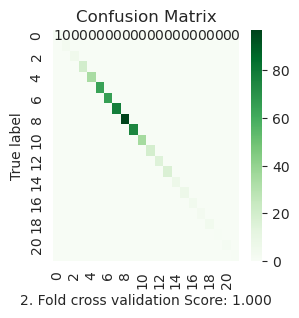

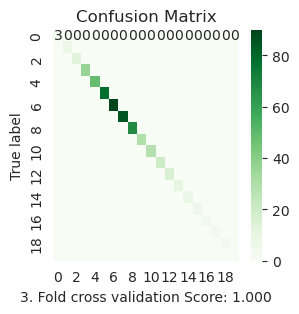

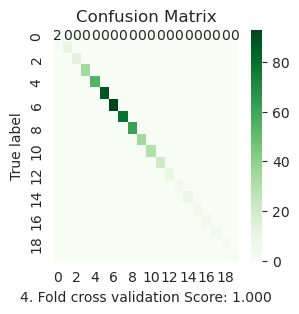

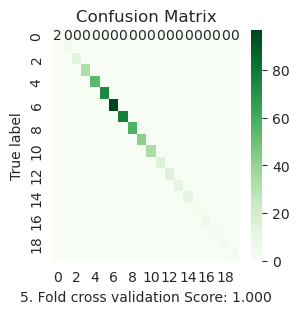

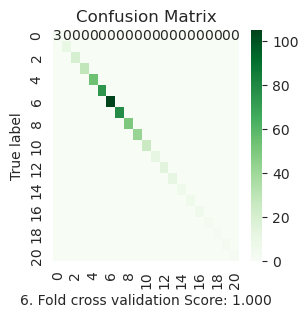

Average accuracy: 1.0


In [188]:
for i, score in enumerate(accuracy_scores):
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Greens')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    i+=1
    plt.xlabel(f'{i}. Fold cross validation Score: {score:.3f}')
    plt.plot()

plt.show()

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print(f"Average accuracy: {avg_accuracy}")